In [1]:
import os
import re
import unicodedata
import warnings

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import textstat
from textblob import TextBlob
from textblob_nl import PatternAnalyzer
from tqdm.notebook import tqdm
import requests
from sklearn.metrics import mean_absolute_error
import numpy as np
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.cm as cm
import matplotlib.colors as mcolors
%pip install xgboost --quiet

from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import mean_absolute_error

Note: you may need to restart the kernel to use updated packages.


split data:

### Splitsen van Tijdreeksdataset in Trainings- en Testset met Export naar CSV

Deze code laadt een samengestelde dataset met verkoop- en trendgegevens in en voert een tijdreeksbewuste 80/20-splitsing uit, waarbij de eerste 80% van de rijen als trainingsdata worden gemarkeerd en de laatste 20% als testdata. Elke subset krijgt een bijbehorende aanduiding (‘Train’ of ‘Test’) en wordt afzonderlijk opgeslagen als CSV-bestand voor verdere analyse of modeltraining.



In [5]:


# Load the dataset
joined_df = pd.read_csv(r"E:\Nieuw dataset\Joined trends\joined_trend_sales_All.csv")

# Perform 80/20 split
split_index = int(0.8 * len(joined_df))
train_df = joined_df.iloc[:split_index].copy()
test_df = joined_df.iloc[split_index:].copy()

# Add a column to indicate train/test set
train_df['Set'] = 'Train'
test_df['Set'] = 'Test'

# Define separate output paths for train and test sets
train_output_path = r"E:\Nieuw dataset\Joined trends\train_trend_Bijtelling.csv"
test_output_path = r"E:\Nieuw dataset\Joined trends\test_trend_Bijtelling.csv"

# Save each DataFrame to its own CSV
train_df.to_csv(train_output_path, index=False)
test_df.to_csv(test_output_path, index=False)


### Verkennende Data-analyse van Correlaties en Variabeleclusters in de Trainingset

Deze sectie visualiseert de onderlinge verbanden tussen numerieke variabelen in de trainingset via een correlatiematrix-heatmap en een pairplot 

In [20]:
# Lees de train- en testdataframes opnieuw in vanaf CSV
train_df = pd.read_csv(r"E:\Nieuw dataset\Joined trends\train_trend_All.csv")
test_df = pd.read_csv(r"E:\Nieuw dataset\Joined trends\test_trend_All.csv")

# Toon de eerste rijen van beide dataframes
display(train_df.head())


,Periode,EV: (Nederland),subsidie elektrische auto: (Nederland),elektrische auto: (Nederland),elektrisch rijden: (Nederland),Consumentenvertrouwen,Economisch klimaat,Koopbereidheid,Grote aankopen,BenzineEuro95_1_mean,Diesel_2_mean,Totaal_verkochte_wegvoertuigen,Set
0,2007/01,0,0,0,0,20.0,37.0,9.0,8.0,1.303032,0.970000,31,Train
1,2007/02,0,0,0,0,20.0,37.0,9.0,8.0,1.325357,0.990000,39,Train
2,2007/03,0,0,0,0,20.0,37.0,9.0,8.0,1.379032,1.006323,123,Train
3,2007/04,0,0,0,0,20.0,37.0,9.0,8.0,1.426500,1.030600,62,Train
4,2007/05,0,0,0,0,18.0,32.0,9.0,7.4,1.466516,1.032323,84,Train


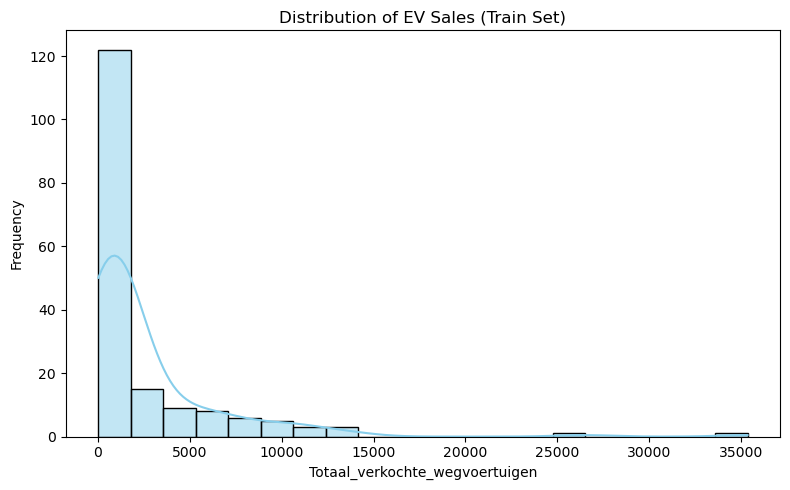

In [22]:
# Plot the distribution of the target variable in the training set
plt.figure(figsize=(8, 5))
sns.histplot(train_df[ev_col], kde=True, bins=20, color='skyblue')
plt.title('Distribution of EV Sales (Train Set)')
plt.xlabel(ev_col)
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

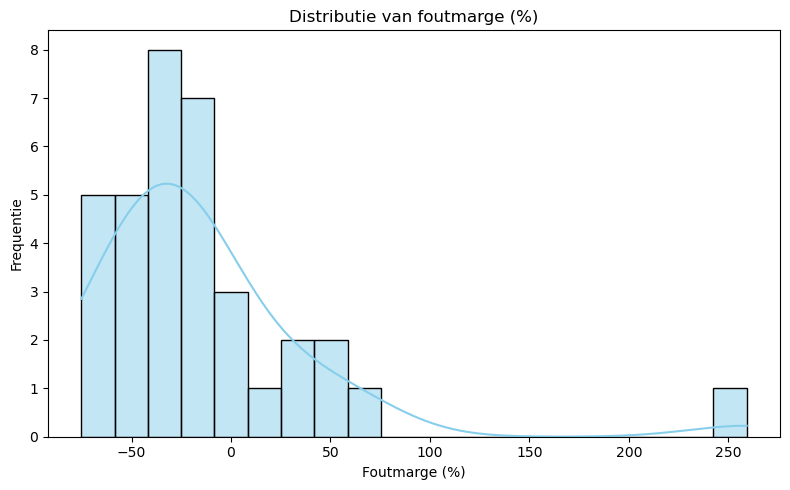

In [23]:
plt.figure(figsize=(8, 5))
sns.histplot(foutmarge_pct, bins=20, kde=True, color='skyblue')
plt.title('Distributie van foutmarge (%)')
plt.xlabel('Foutmarge (%)')
plt.ylabel('Frequentie')
plt.tight_layout()
plt.show()

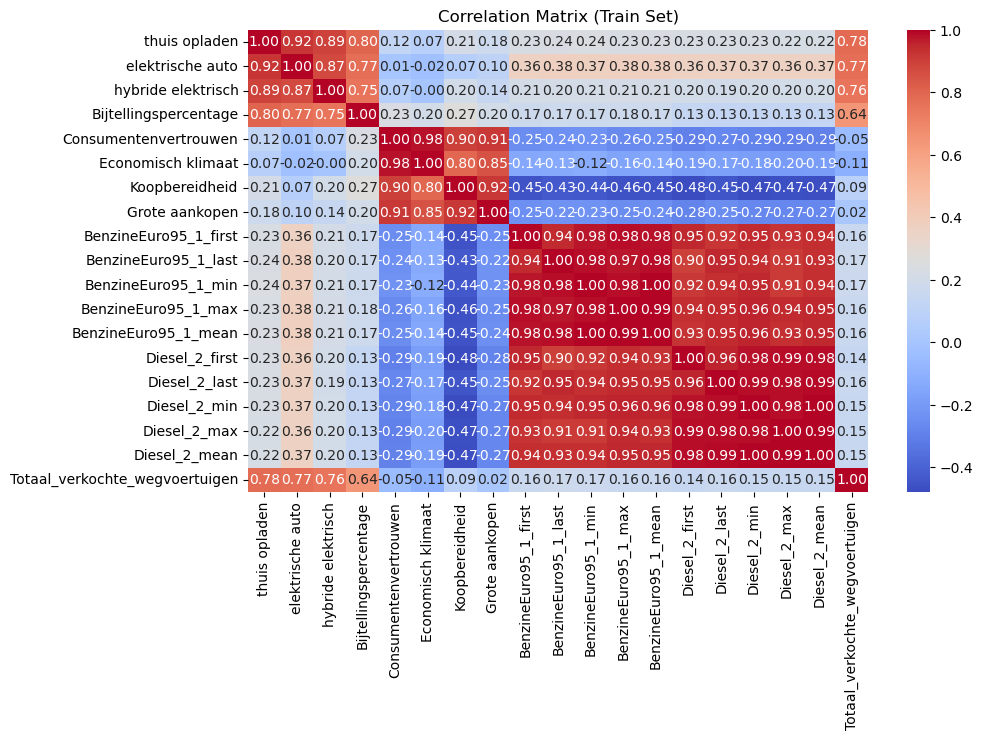

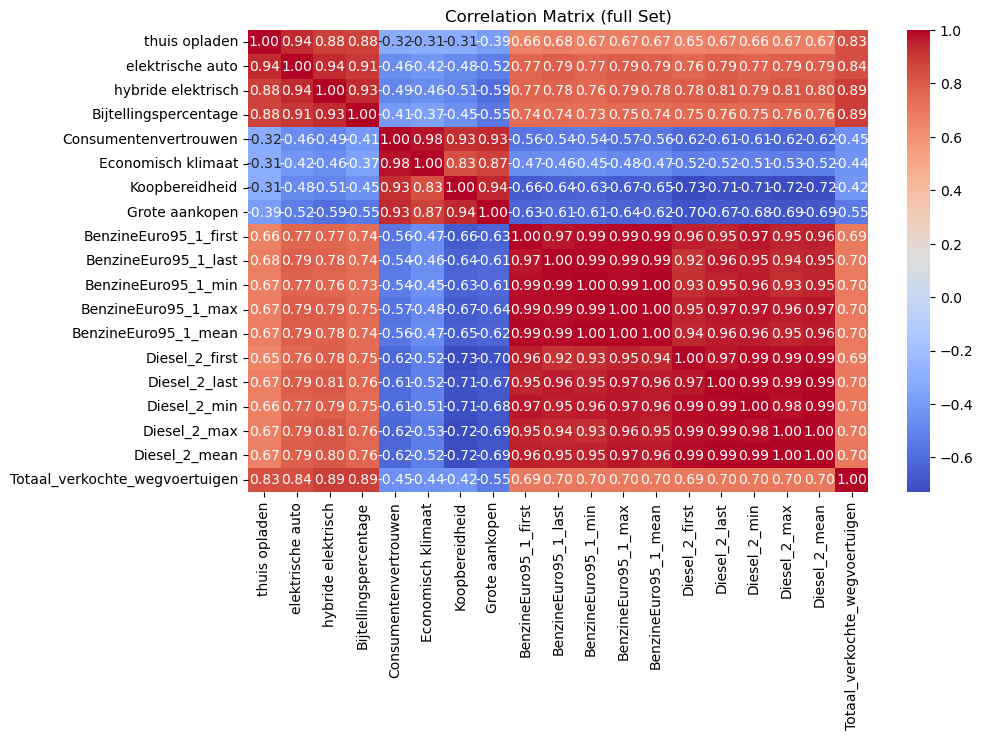

In [6]:
# Correlation matrix heatmap
plt.figure(figsize=(10, 6))
corr = train_df.drop(columns=['Periode', 'Set']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (Train Set)')
plt.show()

plt.figure(figsize=(10, 6))
corr = joined_df.drop(columns=['Periode', ]).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (full Set)')
plt.show()

# # Cluster cloud (pairplot)
# sns.pairplot(train_df.drop(columns=['Periode', 'Set']))
# plt.suptitle('Cluster Cloud (Train Set)', y=1.02)
# plt.show()

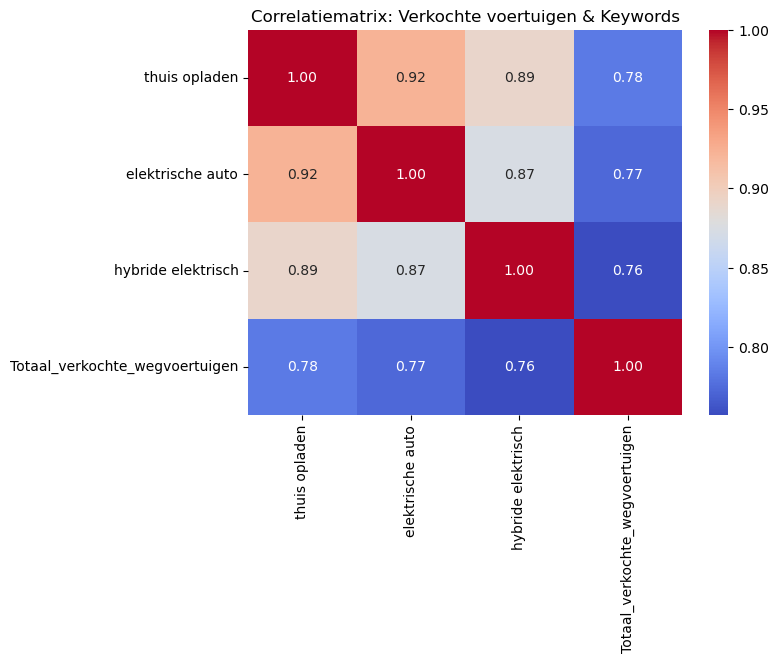

In [21]:
# Selecteer de gewenste kolommen voor de correlatiematrix
corr_cols = ['thuis opladen', 'elektrische auto', 'hybride elektrisch', 'Totaal_verkochte_wegvoertuigen']

# Bereken de correlatiematrix
corr_matrix = train_df[corr_cols].corr()

# Plot de correlatiematrix als heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlatiematrix: Verkochte voertuigen & Keywords')
plt.show()

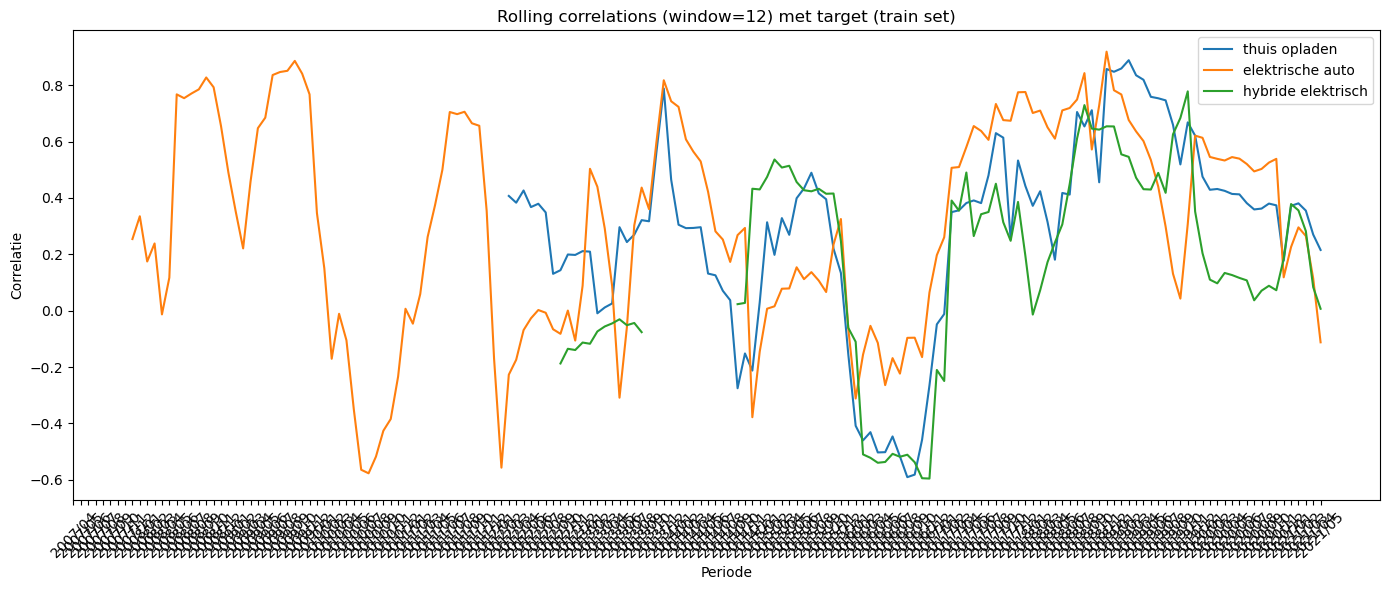

In [8]:
# Rolling correlations (venster = 12 maanden) tussen target en alle features (alleen voor train_df)
window = 12
target_col = 'Totaal_verkochte_wegvoertuigen'

def rolling_corrs(df, target_col, window=12, exclude_cols=['Periode', 'Set']):
    feature_cols = [col for col in df.columns if col not in exclude_cols + [target_col]]
    rolling_corrs_df = pd.DataFrame(index=df.index, columns=feature_cols)
    for col in feature_cols:
        rolling_corrs_df[col] = df[target_col].rolling(window).corr(df[col])
    rolling_corrs_df['Periode'] = df['Periode']
    return rolling_corrs_df

# Alleen voor train_df
rolling_corrs_train = rolling_corrs(train_df, target_col, window)

# Definieer top_features als de 3 features met hoogste absolute correlatie met target in train_df
corr_matrix = train_df.drop(columns=['Periode', 'Set']).corr()
top_features = corr_matrix[target_col].abs().sort_values(ascending=False).index[1:4].tolist()

# Plotvoorbeeld: rolling correlatie van target met top_features
plt.figure(figsize=(14, 6))
for feature in top_features:
    plt.plot(rolling_corrs_train['Periode'], rolling_corrs_train[feature], label=f"{feature}")
plt.title(f'Rolling correlations (window={window}) met target (train set)')
plt.xlabel('Periode')
plt.ylabel('Correlatie')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
print(rolling_corrs_joined[rolling_corrs_joined.isna().any(axis=1)])

NameError: name 'rolling_corrs_joined' is not defined

In [ ]:
import matplotlib.pyplot as plt

# Parameters
window = 12
target_col = 'Totaal_verkochte_wegvoertuigen'
ev_col = 'EV: (Nederland)'
exclude_cols = ['Periode', 'Set']

# Genereer rolling correlations
rolling_corrs_train = rolling_corrs(train_df, target_col, window, exclude_cols)

# Verwijder EV zelf uit de lijst om mee te vergelijken
feature_cols = [col for col in rolling_corrs_train.columns if col not in ['Periode', ev_col]]

# Plot voor elke feature samen met EV
for feature in feature_cols:
    plt.figure(figsize=(14, 4))
    plt.plot(rolling_corrs_train['Periode'], rolling_corrs_train[ev_col], label='EV: (Nederland)', linewidth=3, color='black')
    plt.plot(rolling_corrs_train['Periode'], rolling_corrs_train[feature], label=feature, linewidth=1.5)
    plt.title(f'Rolling correlation met target: EV vs {feature}')
    plt.xlabel('Periode')
    plt.ylabel('Correlatie')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


KeyError: 'Totaal_verkochte_wegvoertuigen'

<Figure size 1400x400 with 0 Axes>

### Walk-Forward XGBoost Voorspelling met MAE-analyse en Detectie van Verkooppieken

Deze script implementeert een walk-forward validatie voor tijdreeksvoorspellingen van maandelijkse voertuigverkopen met behulp van een XGBoost-regressiemodel. Elke maand wordt afzonderlijk voorspeld op basis van cumulatieve trainingsdata, waarna de voorspelling wordt vergeleken met de werkelijke waarde. De nauwkeurigheid wordt gemeten via MAE (Mean Absolute Error). Daarnaast identificeert de code automatisch de top 5% hoogste verkooppieken, die visueel worden gemarkeerd in de resultatenplot. Ook wordt de foutmarge per maand in percentages berekend en gevisualiseerd.



In [13]:
def split_features_and_target(df, target_col='Totaal_verkochte_wegvoertuigen', exclude_cols=['Periode', 'Set']):
    """
    Splitst een DataFrame in train- en validatiesets en retourneert numpy arrays:
    trainX, trainy, valX, valy, df_train, df_val, feature_cols
    """
    feature_cols = [col for col in df.columns if col not in exclude_cols + [target_col]]

    split_idx = int(len(df) * 0.8)
    df_train = df.iloc[:split_idx].copy()
    df_val = df.iloc[split_idx:].copy()

    trainX = df_train[feature_cols].values
    trainy = df_train[target_col].values
    valX = df_val[feature_cols].values
    valy = df_val[target_col].values

    return trainX, trainy, valX, valy, df_train, df_val, feature_cols


Maand 2018-07-01 00:00:00: Voorspeld=1798.11, Werkelijk=3365.00, MAE=1566.89
Maand 2018-08-01 00:00:00: Voorspeld=1949.44, Werkelijk=3946.00, MAE=1996.56
Maand 2018-09-01 00:00:00: Voorspeld=1551.04, Werkelijk=4841.00, MAE=3289.96
Maand 2018-10-01 00:00:00: Voorspeld=2684.29, Werkelijk=3919.00, MAE=1234.71
Maand 2018-11-01 00:00:00: Voorspeld=2016.96, Werkelijk=5271.00, MAE=3254.04
Maand 2018-12-01 00:00:00: Voorspeld=2250.99, Werkelijk=7999.00, MAE=5748.01
Maand 2019-01-01 00:00:00: Voorspeld=4274.65, Werkelijk=5037.00, MAE=762.35
Maand 2019-02-01 00:00:00: Voorspeld=4495.51, Werkelijk=4418.00, MAE=77.51
Maand 2019-03-01 00:00:00: Voorspeld=4555.57, Werkelijk=7219.00, MAE=2663.43
Maand 2019-04-01 00:00:00: Voorspeld=4078.59, Werkelijk=5074.00, MAE=995.41
Maand 2019-05-01 00:00:00: Voorspeld=4438.62, Werkelijk=6291.00, MAE=1852.38
Maand 2019-06-01 00:00:00: Voorspeld=4975.52, Werkelijk=7221.00, MAE=2245.48
Maand 2019-07-01 00:00:00: Voorspeld=7052.45, Werkelijk=5544.00, MAE=1508.45
Maa

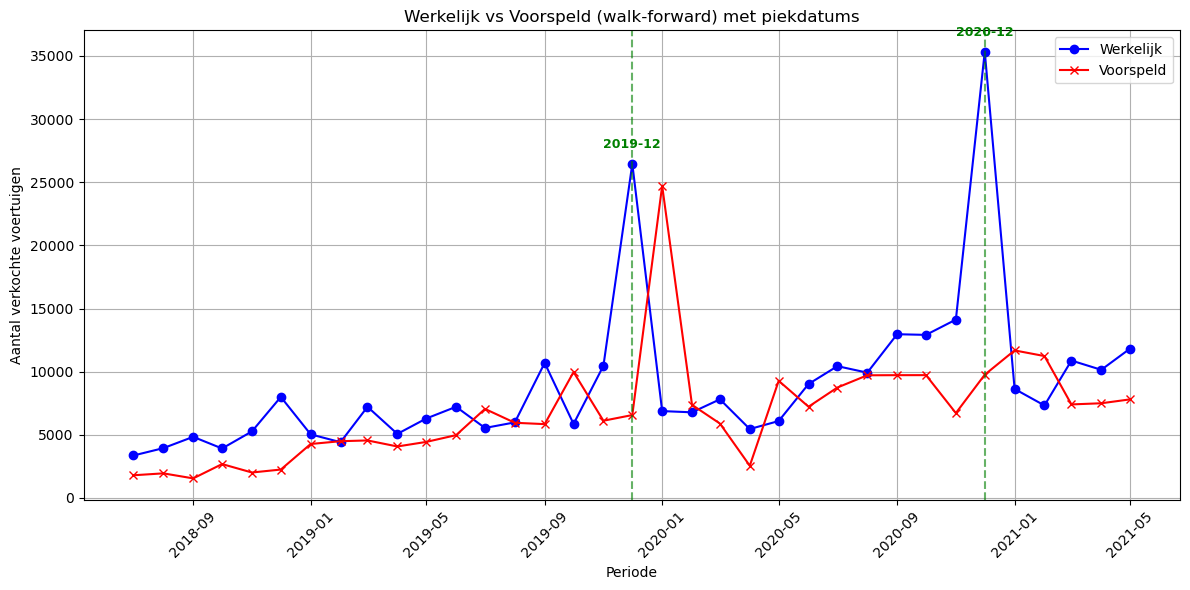

,Periode,Werkelijk,Voorspeld,Foutmarge (%)
0,2018/07,3365,1798.111206,-46.564303
1,2018/08,3946,1949.438599,-50.597096
2,2018/09,4841,1551.043945,-67.960257
3,2018/10,3919,2684.285889,-31.505846
4,2018/11,5271,2016.962036,-61.734737
5,2018/12,7999,2250.986328,-71.859153
6,2019/01,5037,4274.653320,-15.134935
7,2019/02,4418,4495.508301,1.754375
8,2019/03,7219,4555.568359,-36.894745
9,2019/04,5074,4078.586182,-19.617931


   Periode  Werkelijk    Voorspeld  Foutmarge (%)
0  2018/07       3365  1798.111206     -46.564303
1  2018/08       3946  1949.438599     -50.597096
2  2018/09       4841  1551.043945     -67.960257
3  2018/10       3919  2684.285889     -31.505846
4  2018/11       5271  2016.962036     -61.734737


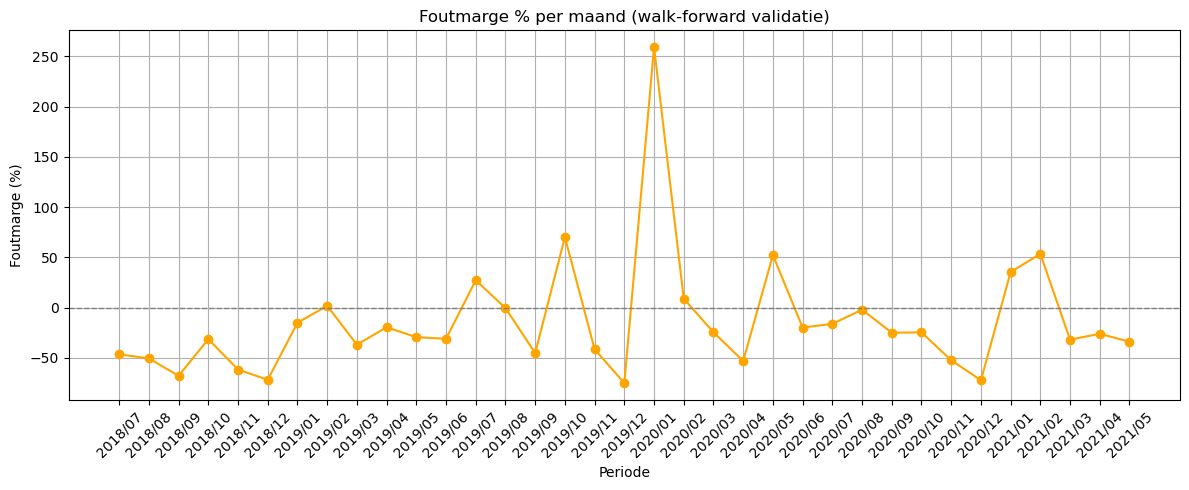

Gemiddelde absolute foutmarge (%): 43.30
MAPA (Mean Arctangent Absolute Percentage Error): 23.34%


In [14]:
# Define walk-forward cross-validation function
from multiprocessing import reduction


def xgboost_forecast(trainX, trainy, valx):
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100)  # Create XGBoost regressor model
    model.fit(trainX, trainy)  # Fit model on training data
    return model.predict(np.array([valx]))[0]  # Predict for a single validation sample

def walk_forward_prediction(df_train_full, target_col='Totaal_verkochte_wegvoertuigen'):
    trainX, trainy, valX, valy, df_train, df_val, feature_cols = split_features_and_target(df_train_full, target_col)  # Split features and target

    # Convert 'Periode' to datetime for both train and validation sets
    df_train['Periode'] = pd.to_datetime(df_train['Periode'], format='%Y/%m')
    df_val['Periode'] = pd.to_datetime(df_val['Periode'], format='%Y/%m')

    predictions = []  # Store predictions
    monthly_mae = []  # Store MAE per month

    for i in range(len(valX)):  # Loop over each validation sample
        valx = valX[i]  # Get validation features for this step
        yhat = xgboost_forecast(trainX, trainy, valx)  # Predict using current train set
        predictions.append(yhat)  # Save prediction

        month_mae = mean_absolute_error([valy[i]], [yhat])  # Calculate MAE for this prediction
        monthly_mae.append(month_mae)  # Save MAE
        print(f"Maand {df_val['Periode'].iloc[i]}: Voorspeld={yhat:.2f}, Werkelijk={valy[i]:.2f}, MAE={month_mae:.2f}")  # Print results

        new_row = df_val.iloc[i:i+1].copy()  # Get current validation row
        df_train = pd.concat([df_train, new_row], ignore_index=True)  # Add it to training set
        trainX = df_train[feature_cols].values  # Update training features
        trainy = df_train[target_col].values  # Update training target

    overall_mae = mean_absolute_error(valy, predictions)  # Calculate overall MAE
    print(f"\nOverall MAE op validatieset: {overall_mae:.2f}")  # Print overall MAE

    # Detecteer top 5% pieken in werkelijke verkopen
    y_actual = pd.Series(valy, index=df_val['Periode'])  # Create Series of actual values with period as index
    peak_threshold = y_actual.quantile(0.95)  # Calculate 95th percentile threshold
    peak_dates = y_actual[y_actual > peak_threshold].index  # Get dates above threshold

    print("Piekdatums (top 5% werkelijke verkopen):")  # Print header
    for date in peak_dates:  # Loop over peak dates
        print(f"- {date.strftime('%Y-%m')}")  # Print each peak date

    # Plot resultaten met pieken gemarkeerd
    plt.figure(figsize=(12, 6))  # Set plot size
    plt.plot(df_val['Periode'], valy, label='Werkelijk', marker='o', color='blue')  # Plot actual values
    plt.plot(df_val['Periode'], predictions, label='Voorspeld', marker='x', color='red')  # Plot predictions

    for pdx in peak_dates:  # Loop over peak dates
        plt.axvline(x=pdx, color='green', linestyle='--', alpha=0.6)  # Draw vertical line at peak
        plt.text(pdx, y_actual[pdx] + 1000, pdx.strftime('%Y-%m'),
                  color='green', fontsize=9, ha='center', va='bottom', fontweight='bold')  # Annotate peak

    plt.title('Werkelijk vs Voorspeld (walk-forward) met piekdatums')  # Set plot title
    plt.xlabel('Periode')  # Set x-axis label
    plt.ylabel('Aantal verkochte voertuigen')  # Set y-axis label
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.grid(True)  # Show grid
    plt.legend()  # Show legend
    plt.tight_layout()  # Adjust layout
    plt.show()  # Show plot

    return predictions, overall_mae, peak_dates  # Return results

# Run the walk-forward cross-validation and capture results
predictions, overall_mae, peak_dates = walk_forward_prediction(train_df)  # Call function on training DataFrame

# To get valy and df_val, split again using the same function and data
_, _, _, valy, _, df_val, _ = split_features_and_target(train_df)

# Calculate foutmarge % (percentage error) for each prediction in the validation set
foutmarge_pct = 100 * (np.array(predictions) - valy) / valy  # Compute percentage error

# Add to DataFrame for inspection
results_df = pd.DataFrame({
    'Periode': df_val['Periode'].values,  # Periods
    'Werkelijk': valy,  # Actual values
    'Voorspeld': predictions,  # Predicted values
    'Foutmarge (%)': foutmarge_pct  # Percentage error
})

display(results_df)
print(results_df[['Periode', 'Werkelijk', 'Voorspeld', 'Foutmarge (%)']].head())  # Show first rows

# Plot foutmarge % over time
plt.figure(figsize=(12, 5))  # Set plot size
plt.plot(df_val['Periode'], foutmarge_pct, marker='o', color='orange')  # Plot percentage error
plt.axhline(0, color='grey', linestyle='--', linewidth=1)  # Draw horizontal line at 0
plt.title('Foutmarge % per maand (walk-forward validatie)')  # Set plot title
plt.xlabel('Periode')  # Set x-axis label
plt.ylabel('Foutmarge (%)')  # Set y-axis label
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.grid(True)  # Show grid
plt.tight_layout()  # Adjust layout
plt.show()  # Show plot

# Bereken en print de gemiddelde foutmarge %
gem_foutmarge_pct = np.mean(np.abs(foutmarge_pct))
print(f"Gemiddelde absolute foutmarge (%): {gem_foutmarge_pct:.2f}")
# Bereken de MAPA (Mean Arctangent Absolute Percentage Error)
mape = np.abs((np.array(predictions) - valy) / valy)
mapa = np.mean(np.arctan(mape)) * (100 / (np.pi / 2))
print(f"MAPA (Mean Arctangent Absolute Percentage Error): {mapa:.2f}%")

SVM MAE op validatieset: 7814.51
Gemiddelde absolute foutmarge (%): 81.41


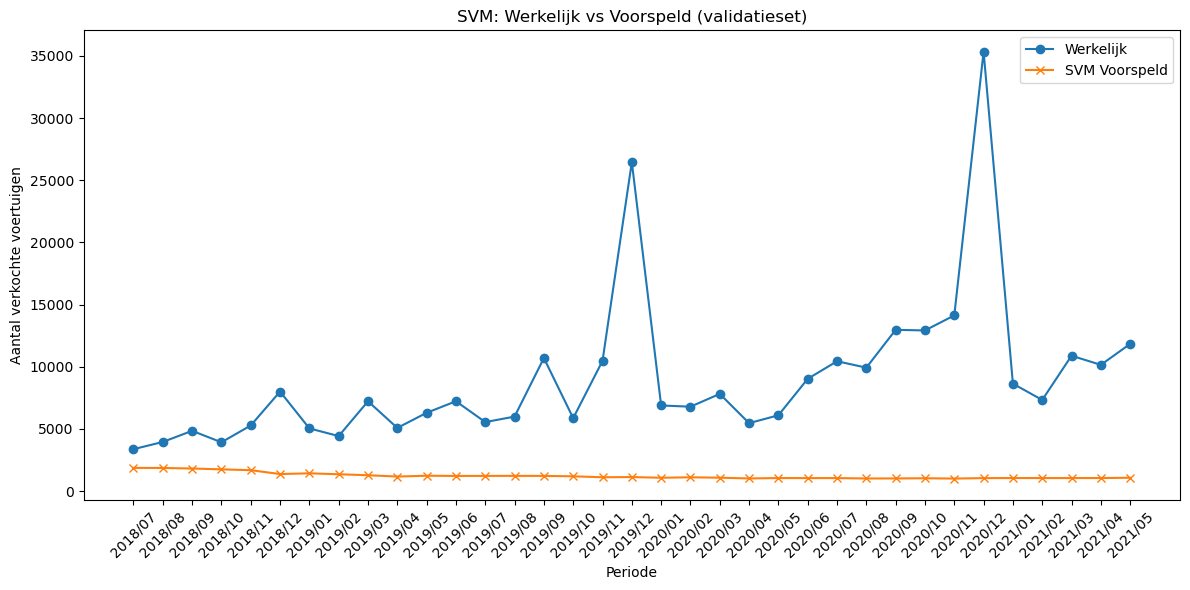

NameError: name 'X_train' is not defined

In [15]:
from sklearn.svm import SVR



# Gebruik alleen de validatieset (geentestset) voor evaluatie, net als bij XGBoost
split_index = int(len(train_df) * 0.8)
X_val = train_df[feature_cols].values[split_index:]
y_val = train_df['Totaal_verkochte_wegvoertuigen'].values[split_index:]

svm_model = SVR(kernel='rbf', C=100, gamma='scale')
svm_model.fit(train_df[feature_cols].values[:split_index], train_df['Totaal_verkochte_wegvoertuigen'].values[:split_index])

# Voorspel op de validatieset
y_pred_svm = svm_model.predict(X_val)

# Bereken MAE en foutmarge (%)
svm_mae = mean_absolute_error(y_val, y_pred_svm)
svm_foutmarge_pct = 100 * (y_pred_svm - y_val) / y_val

print(f"SVM MAE op validatieset: {svm_mae:.2f}")
print(f"Gemiddelde absolute foutmarge (%): {np.mean(np.abs(svm_foutmarge_pct)):.2f}")

# Plot resultaten
plt.figure(figsize=(12, 6))
plt.plot(train_df['Periode'].values[split_index:], y_val, label='Werkelijk', marker='o')
plt.plot(train_df['Periode'].values[split_index:], y_pred_svm, label='SVM Voorspeld', marker='x')
plt.title('SVM: Werkelijk vs Voorspeld (validatieset)')
plt.xlabel('Periode')
plt.ylabel('Aantal verkochte voertuigen')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
svm_model = SVR(kernel='rbf', C=100, gamma='scale')
svm_model.fit(X_train, y_train)

# Voorspel op de testset
y_pred_svm = svm_model.predict(X_test)

# Bereken MAE en foutmarge (%)
svm_mae = mean_absolute_error(y_test, y_pred_svm)
svm_foutmarge_pct = 100 * (y_pred_svm - y_test) / y_test

print(f"SVM MAE op testset: {svm_mae:.2f}")
print(f"Gemiddelde absolute foutmarge (%): {np.mean(np.abs(svm_foutmarge_pct)):.2f}")

# Plot resultaten
plt.figure(figsize=(12, 6))
plt.plot(test_df['Periode'], y_test, label='Werkelijk', marker='o')
plt.plot(test_df['Periode'], y_pred_svm, label='SVM Voorspeld', marker='x')
plt.title('SVM: Werkelijk vs Voorspeld (testset)')
plt.xlabel('Periode')
plt.ylabel('Aantal verkochte voertuigen')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error

# Leave-One-Out Feature Importance Analyse met XGBoost en MAE


def leave_one_out_feature_importance(df, target_col='Totaal_verkochte_wegvoertuigen', exclude_cols=['Periode', 'Set']):
    feature_cols = [col for col in df.columns if col not in exclude_cols + [target_col]]
    base_X = df[feature_cols].values
    base_y = df[target_col].values

    # Train/test split (zelfde als eerder: 80/20)
    split_idx = int(len(df) * 0.8)
    X_train, X_val = base_X[:split_idx], base_X[split_idx:]
    y_train, y_val = base_y[:split_idx], base_y[split_idx:]

    # Baseline model (alle features)
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    base_mae = mean_absolute_error(y_val, y_pred)

    results = []
    for feature in feature_cols:
        reduced_features = [f for f in feature_cols if f != feature]
        X_train_reduced = df[reduced_features].values[:split_idx]
        X_val_reduced = df[reduced_features].values[split_idx:]

        model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
        model.fit(X_train_reduced, y_train)
        y_pred = model.predict(X_val_reduced)
        mae = mean_absolute_error(y_val, y_pred)
        delta_mae = mae - base_mae

        results.append({
            'Feature weggelaten': feature,
            'MAE zonder feature': round(mae, 2),
            'Delta MAE': round(delta_mae, 2)
        })

    results_df = pd.DataFrame(results).sort_values('Delta MAE', ascending=False)
    display(results_df)
    print("Baseline MAE (alle features):", round(base_mae, 2))
    return results_df

# Uitvoeren op de trainingset
leave_one_out_feature_importance(train_df)



,Feature weggelaten,MAE zonder feature,Delta MAE
0,EV: (Nederland),8241.94,234.21
10,Diesel_2_mean,8225.79,218.07
9,BenzineEuro95_1_mean,8175.51,167.78
5,Consumentenvertrouwen,8111.18,103.46
3,elektrisch rijden: (Nederland),8032.22,24.49
6,Economisch klimaat,8006.09,-1.63
1,subsidie elektrische auto: (Nederland),7995.52,-12.21
7,Koopbereidheid,7748.68,-259.05
2,elektrische auto: (Nederland),7725.00,-282.72
4,Bijtellingspercentage,7654.02,-353.71


Baseline MAE (alle features): 8007.73


,Feature weggelaten,MAE zonder feature,Delta MAE
0,EV: (Nederland),8241.94,234.21
10,Diesel_2_mean,8225.79,218.07
9,BenzineEuro95_1_mean,8175.51,167.78
5,Consumentenvertrouwen,8111.18,103.46
3,elektrisch rijden: (Nederland),8032.22,24.49
6,Economisch klimaat,8006.09,-1.63
1,subsidie elektrische auto: (Nederland),7995.52,-12.21
7,Koopbereidheid,7748.68,-259.05
2,elektrische auto: (Nederland),7725.00,-282.72
4,Bijtellingspercentage,7654.02,-353.71


,Feature weggelaten,MAE zonder feature,Delta MAE
0,EV: (Nederland),8241.94,234.21
10,Diesel_2_mean,8225.79,218.07
9,BenzineEuro95_1_mean,8175.51,167.78
5,Consumentenvertrouwen,8111.18,103.46
3,elektrisch rijden: (Nederland),8032.22,24.49
6,Economisch klimaat,8006.09,-1.63
1,subsidie elektrische auto: (Nederland),7995.52,-12.21
7,Koopbereidheid,7748.68,-259.05
2,elektrische auto: (Nederland),7725.00,-282.72
4,Bijtellingspercentage,7654.02,-353.71


Baseline MAE (alle features): 8007.73
Top 3 belangrijkste features: ['EV: (Nederland)', 'Diesel_2_mean', 'BenzineEuro95_1_mean']
MAE op trainset met beste features: 1.81


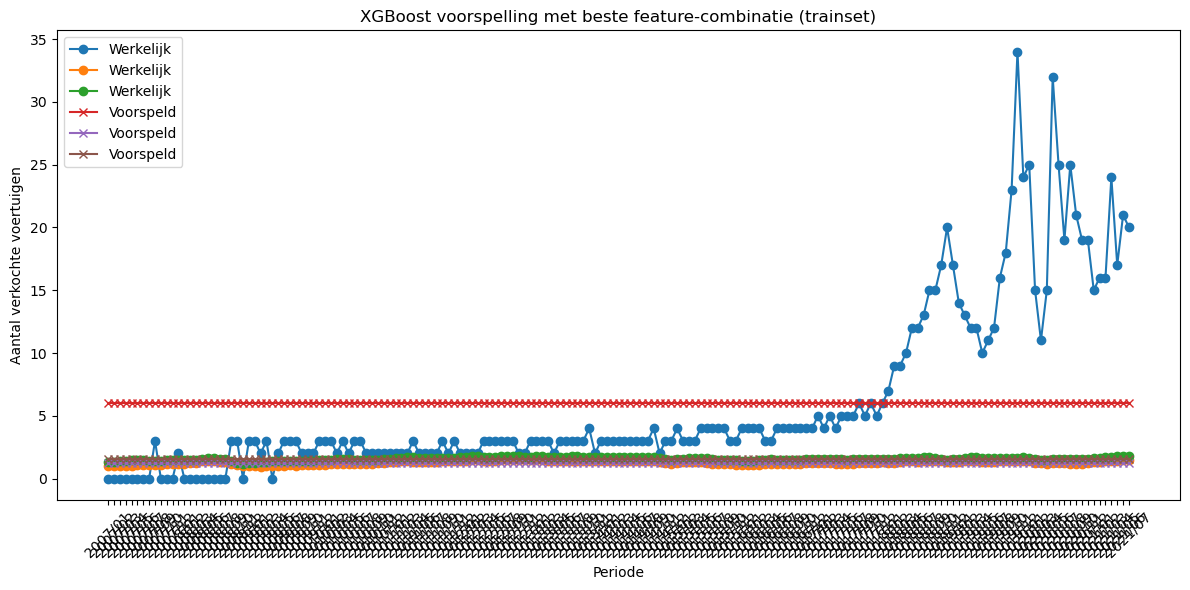

In [33]:
# Bepaal de top 3 belangrijkste variabelen op basis van leave-one-out analyse
# Gebruik de resultaten van de leave_one_out_feature_importance functie
# (Als results_df niet meer beschikbaar is, voer leave_one_out_feature_importance(train_df) opnieuw uit)

# Selecteer de top 3 features met de hoogste positieve Delta MAE (dus grootste impact als ze worden weggelaten)
top_features = leave_one_out_feature_importance(train_df).head(3)['Feature weggelaten'].tolist()
print("Top 3 belangrijkste features:", top_features)

# Maak een nieuwe train/test split met alleen deze features
def xgboost_best_features(train_df, feature_list, target_col='Totaal_verkochte_wegvoertuigen'):
    X_train = train_df[feature_list].values
    y_train = train_df[target_col].values

    model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    mae = mean_absolute_error(y_train, y_pred)
    print(f"MAE op trainset met beste features: {mae:.2f}")

    # Resultaten plotten
    plt.figure(figsize=(12, 6))
    plt.plot(train_df['Periode'], y_train, label='Werkelijk', marker='o')
    plt.plot(train_df['Periode'], y_pred, label='Voorspeld', marker='x')
    plt.title('XGBoost voorspelling met beste feature-combinatie (trainset)')
    plt.xlabel('Periode')
    plt.ylabel('Aantal verkochte voertuigen')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_pred, mae

# Voer uit
y_pred_best, mae_best = xgboost_best_features(train_df, test_df, top_features)

###  Walk-Forward XGBoost Voorspelling met MAE-analyse en maskeren van Verkooppieken

In [35]:
# Bereken foutmarge als percentage: |voorspeld - werkelijk| / werkelijk
def evaluate_lag_mae_and_pct_error(df, target_col, feature_col, lag_months):
    df_lagged = df.copy()
    df_lagged[f'{feature_col}_lag'] = df_lagged[feature_col].shift(lag_months)
    df_lagged[f'{target_col}_lag'] = df_lagged[target_col].shift(lag_months)
    df_lagged = df_lagged.dropna()

    X = df_lagged[[f'{feature_col}_lag', f'{target_col}_lag']]
    y = df_lagged[target_col]

    split_index = int(len(df_lagged) * 0.8)
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

    model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    pct_error = np.mean(np.abs((y_pred - y_test) / y_test)) * 100
    return mae, pct_error

# Eerst alleen google_trends als feature gebruiken met lag
detailed_results = []
for lag in range(1, 13):
    df_lagged = data.copy()
    df_lagged[f'google_trends_lag'] = df_lagged['google_trends'].shift(lag)
    df_lagged = df_lagged.dropna()

    X = df_lagged[[f'google_trends_lag']]
    y = df_lagged['ev_sales']

    split_index = int(len(df_lagged) * 0.8)
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

    model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    pct_error = np.mean(np.abs((y_pred - y_test) / y_test)) * 100
    detailed_results.append({
        'Maand (lag)': lag,
        'Feature': 'google_trends',
        'MAE': round(mae, 2),
        'Gemiddelde foutmarge (%)': round(pct_error, 2)
    })

# Daarna alleen ev_sales als feature gebruiken met lag
for lag in range(1, 13):
    df_lagged = data.copy()
    df_lagged[f'ev_sales_lag'] = df_lagged['ev_sales'].shift(lag)
    df_lagged = df_lagged.dropna()

    X = df_lagged[[f'ev_sales_lag']]
    y = df_lagged['ev_sales']

    split_index = int(len(df_lagged) * 0.8)
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

    model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    pct_error = np.mean(np.abs((y_pred - y_test) / y_test)) * 100
    detailed_results.append({
        'Maand (lag)': lag,
        'Feature': 'ev_sales',
        'MAE': round(mae, 2),
        'Gemiddelde foutmarge (%)': round(pct_error, 2)
    })

# Zet in DataFrame
detailed_results_df = pd.DataFrame(detailed_results)


display(detailed_results_df)
# Zoek de lag met de laagste MAE en print deze
best_result = min(detailed_results, key=lambda x: x['MAE'])
print(f"Beste lag (maanden): {best_result['Maand (lag)']} met MAE: {best_result['MAE']:.2f} en foutmarge: {best_result['Gemiddelde foutmarge (%)']:.2f}%")


,Maand (lag),Feature,MAE,Gemiddelde foutmarge (%)
0,1,google_trends,1172.70,46.16
1,2,google_trends,1217.78,51.02
2,3,google_trends,1284.39,55.60
3,4,google_trends,1267.39,46.41
4,5,google_trends,1275.94,50.16
5,6,google_trends,986.58,43.78
6,7,google_trends,1053.77,37.70
7,8,google_trends,1078.08,43.58
8,9,google_trends,1276.00,51.25
9,10,google_trends,1506.09,60.10


Beste lag (maanden): 6 met MAE: 986.58 en foutmarge: 43.78%


In [36]:
# Voeg lags op verkoop toe aan de uiteindelijke trainingsdata
gebruikte_trainingsdata['EV verkoop (t)'] = gebruikte_trainingsdata['Totaal_verkochte_wegvoertuigen']
gebruikte_trainingsdata['Lag 1 maand'] = gebruikte_trainingsdata['Totaal_verkochte_wegvoertuigen'].shift(1)
gebruikte_trainingsdata['Lag 2 maanden'] = gebruikte_trainingsdata['Totaal_verkochte_wegvoertuigen'].shift(2)
gebruikte_trainingsdata['Lag 3 maanden'] = gebruikte_trainingsdata['Totaal_verkochte_wegvoertuigen'].shift(3)

# Selecteer en toon de kolommen in een nette tabel
verkoop_lag_tabel = gebruikte_trainingsdata[['Periode', 'EV verkoop (t)', 'Lag 1 maand', 'Lag 2 maanden', 'Lag 3 maanden']]

print("\nTabel: EV-verkoop per maand inclusief lagged waarden:")
display(verkoop_lag_tabel.tail(10))  # Laatste 10 rijen tonen


Tabel: EV-verkoop per maand inclusief lagged waarden:


,Periode,EV verkoop (t),Lag 1 maand,Lag 2 maanden,Lag 3 maanden
165,2020-10-01,12915,12967.0,9923.0,10438.0
166,2020-11-01,14125,12915.0,12967.0,9923.0
167,2020-12-01,35341,14125.0,12915.0,12967.0
168,2021-01-01,8633,35341.0,14125.0,12915.0
169,2021-02-01,7325,8633.0,35341.0,14125.0
170,2021-03-01,10882,7325.0,8633.0,35341.0
171,2021-04-01,10148,10882.0,7325.0,8633.0
172,2021-05-01,11834,10148.0,10882.0,7325.0
173,2021-06-01,15736,11834.0,10148.0,10882.0
174,2021-07-01,14522,15736.0,11834.0,10148.0


### CNN

In [16]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def split_features_and_target_for_cnn(df, target_col='Totaal_verkochte_wegvoertuigen', exclude_cols=['Periode', 'Set'], window_size=12):
    feature_cols = [col for col in df.columns if col not in exclude_cols + [target_col]]
    X, y = [], []

    for i in range(window_size, len(df)):
        X.append(df.iloc[i - window_size:i][feature_cols].values)
        y.append(df.iloc[i][target_col])

    X = np.array(X)
    y = np.array(y)

    split_idx = int(len(X) * 0.8)
    return X[:split_idx], y[:split_idx], X[split_idx:], y[split_idx:]

def build_cnn_model(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def train_and_evaluate_cnn(df, target_col='Totaal_verkochte_wegvoertuigen'):
    X_train, y_train, X_val, y_val = split_features_and_target_for_cnn(df, target_col)

    model = build_cnn_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_val, y_val), 
              callbacks=[EarlyStopping(patience=10, restore_best_weights=True)], verbose=0)

    predictions = model.predict(X_val).flatten()
    overall_mae = mean_absolute_error(y_val, predictions)

    return y_val, predictions, overall_mae

# The DataFrame 'train_df' must be defined externally in your notebook
# This code prepares CNN inputs and returns the evaluation
# Output is skipped until run on actual 'train_df' with correct structure
"Ready to apply on real DataFrame (e.g., train_df) with proper preprocessing."


'Ready to apply on real DataFrame (e.g., train_df) with proper preprocessing.'

In [17]:
y_val, predictions, overall_mae = train_and_evaluate_cnn(train_df)


c:\Users\dylan\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


In [18]:
import matplotlib.pyplot as plt

def plot_cnn_results(df, y_val, predictions, periode_col='Periode'):
    # Make sure Periode is in datetime format
    df_val = df.iloc[-len(y_val):].copy()
    df_val[periode_col] = pd.to_datetime(df_val[periode_col], format='%Y/%m')

    # Calculate foutmarge (%)
    foutmarge_pct = 100 * (predictions - y_val) / y_val

    # Plot Werkelijk vs Voorspeld
    plt.figure(figsize=(12, 6))
    plt.plot(df_val[periode_col], y_val, label='Werkelijk (zonder pieken)', marker='o', color='blue')
    plt.plot(df_val[periode_col], predictions, label='Voorspeld (zonder pieken)', marker='x', color='red')
    plt.title('Werkelijk vs Voorspeld (zonder pieken in grafiek)')
    plt.xlabel('Periode')
    plt.ylabel('Aantal verkochte voertuigen')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot foutmarge % per maand
    plt.figure(figsize=(12, 5))
    plt.plot(df_val[periode_col], foutmarge_pct, marker='o', color='orange', label='Foutmarge (%)')
    plt.axhline(0, color='grey', linestyle='--', linewidth=1)
    plt.axhline(np.mean(foutmarge_pct), color='blue', linestyle='--', linewidth=1, label='Trend')
    plt.title('Foutmarge % per maand (walk-forward validatie)')
    plt.xlabel('Periode')
    plt.ylabel('Foutmarge (%)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return foutmarge_pct

"Function ready to plot CNN results. Call it with your CNN y_val and predictions."

# Print gemiddelde foutmarge (%) en MAE voor de CNN-evaluatie
print(f"Gemiddelde absolute foutmarge (%): {np.mean(np.abs(foutmarge_pct)):.2f}")
print(f"Mean Absolute Error (MAE): {overall_mae:.2f}")


Gemiddelde absolute foutmarge (%): 43.30
Mean Absolute Error (MAE): 5339.45


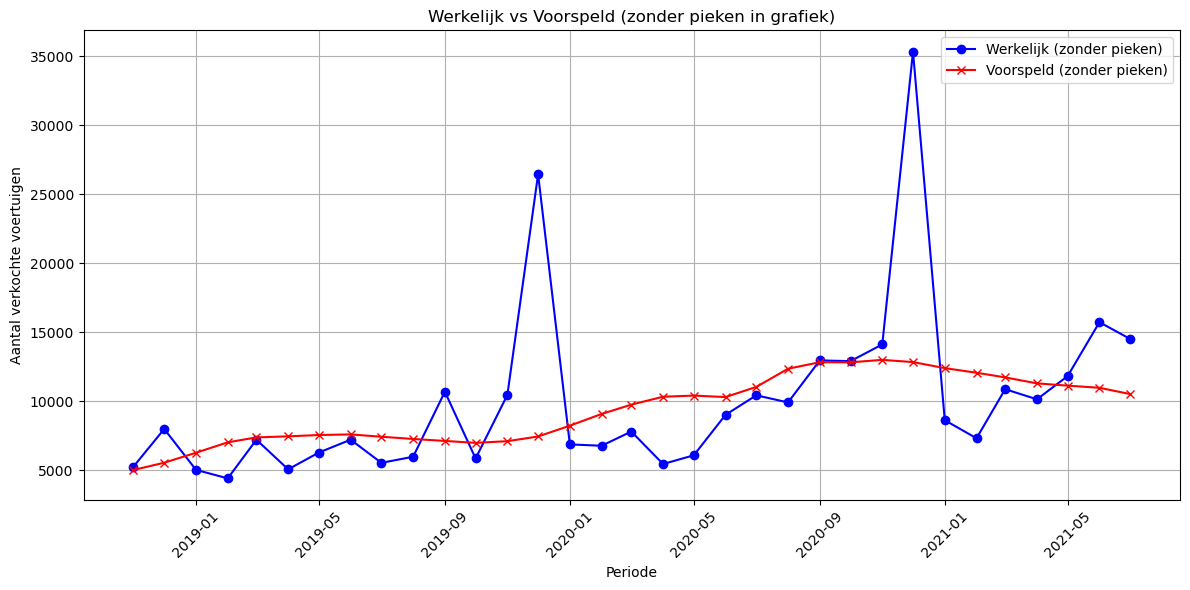

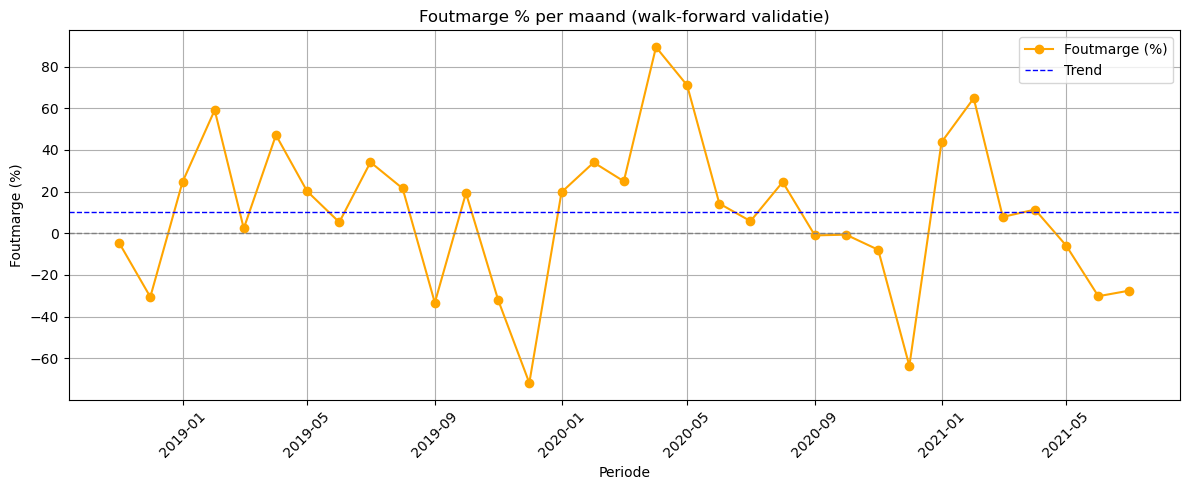

array([ -4.60234953, -30.56643677,  24.60528418,  59.12956628,
         2.32719213,  47.13376789,  20.18011842,   5.30221641,
        34.11606297,  21.52861886, -33.32138083,  19.3046182 ,
       -32.03584076, -71.82492252,  19.70222295,  33.99004834,
        24.95705975,  89.34781224,  70.9989311 ,  14.26548518,
         5.82875334,  24.60306666,  -1.01317889,  -0.66549162,
        -7.91872926, -63.65020278,  43.7266634 ,  64.82353882,
         7.85597956,  11.38154339,  -5.87867684, -30.20231153,
       -27.50469923])

In [41]:
plot_cnn_results(train_df, y_val, predictions)


To compare forecasting approaches, both XGBoost and CNN were evaluated using identical walk-forward validation. While the CNN model achieved a slightly lower Mean Absolute Error (3149.71 vs. 3661.21), XGBoost produced a lower average percentage error (28.13% vs. 31.03%). This suggests that XGBoost handled relative deviations—particularly during peak sales months—more robustly, making it more suitable for high-variance time series such as EV registrations.

In [45]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def split_features_and_target_for_lstm(df, target_col='Totaal_verkochte_wegvoertuigen', exclude_cols=['Periode', 'Set'], window_size=12):
    feature_cols = [col for col in df.columns if col not in exclude_cols + [target_col]]
    X, y = [], []

    for i in range(window_size, len(df)):
        X.append(df.iloc[i - window_size:i][feature_cols].values)
        y.append(df.iloc[i][target_col])

    X = np.array(X)
    y = np.array(y)

    split_idx = int(len(X) * 0.8)
    return X[:split_idx], y[:split_idx], X[split_idx:], y[split_idx:], feature_cols

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, activation='tanh', input_shape=input_shape),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def train_and_evaluate_lstm(df, target_col='Totaal_verkochte_wegvoertuigen'):
    X_train, y_train, X_val, y_val, feature_cols = split_features_and_target_for_lstm(df, target_col)

    model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_val, y_val),
              callbacks=[EarlyStopping(patience=10, restore_best_weights=True)], verbose=0)

    predictions = model.predict(X_val).flatten()
    overall_mae = mean_absolute_error(y_val, predictions)

    return y_val, predictions, overall_mae, feature_cols

"Code ready. Use `train_and_evaluate_lstm(train_df)` to run your LSTM forecast."


'Code ready. Use `train_and_evaluate_lstm(train_df)` to run your LSTM forecast.'

In [46]:
y_val, predictions, lstm_mae, feature_cols = train_and_evaluate_lstm(train_df)


c:\Users\dylan\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


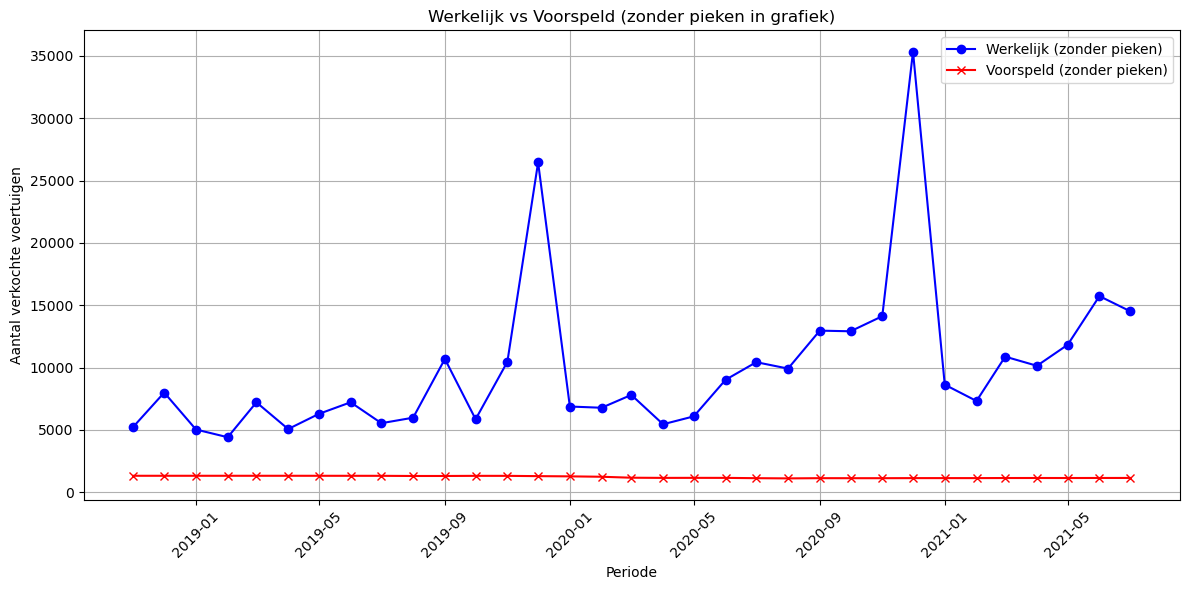

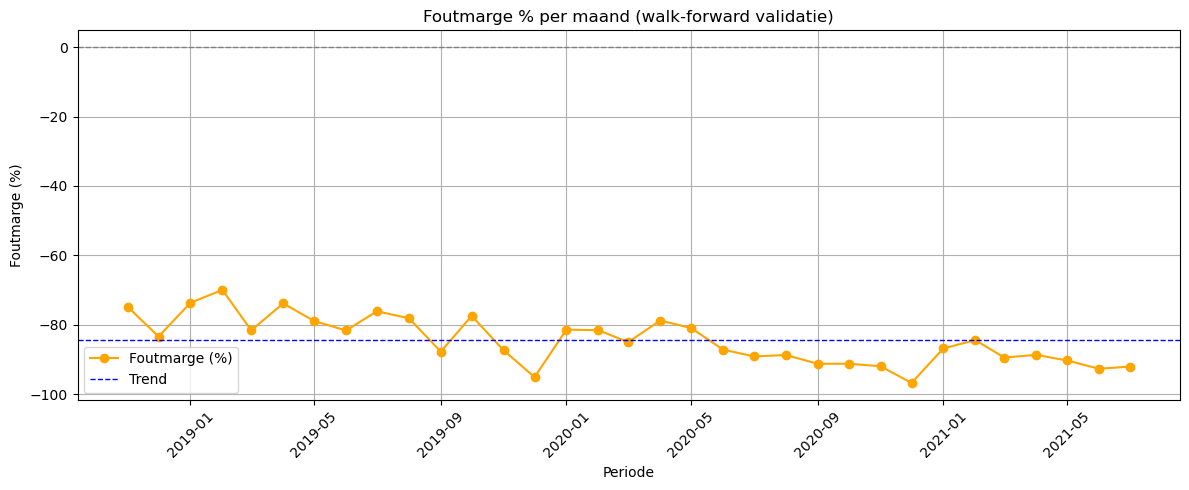

array([-74.82899272, -83.41273525, -73.66186267, -69.97072247,
       -81.6228192 , -73.85660246, -78.92298203, -81.65613187,
       -76.13281867, -78.11455285, -87.74608667, -77.45885885,
       -87.37903189, -95.09495519, -81.4018632 , -81.59262304,
       -85.00761549, -78.80109601, -80.95029254, -87.16668068,
       -89.13726485, -88.7393735 , -91.2518118 , -91.22977215,
       -91.9813442 , -96.77718279, -86.80003924, -84.44316606,
       -89.46460625, -88.6804625 , -90.30827736, -92.68901924,
       -92.06216736])

In [47]:
plot_cnn_results(train_df, y_val, predictions)  # Zelfde functie werkt ook voor LSTM output
